## Load packages

In [17]:
# built-in libraries
from datetime import date
import os
from typing import *
import math
# third-party libraries
import pandas as pd
import numpy as np
import scipy
# local application
from auto_ml_validation.validation_package.algorithms.xgboost import XGBoostClassifier
from auto_ml_validation.validation_package.algorithms.random_forest import RFClassifier
from auto_ml_validation.validation_package.process_data import split_x_y, process_data
from auto_ml_validation.validation_package.benchmark_pipeline import auto_benchmark, save_benchmark_output
from auto_ml_validation.validation_package.train_pipeline import train
from auto_ml_validation.validation_package.evaluation.statistical_metrics_evaluator import StatisticalMetricsEvaluator
from auto_ml_validation.validation_package.evaluation.transparency_metrics_evaluator import TransparencyMetricsEvaluator
from auto_ml_validation.validation_package.evaluation.performance_metrics_evaluator import evaluate_performance

## Benchmarking pipeline

### Benchmarking setup

Load raw datasets & specify target + categorical columns

In [2]:
train_raw = pd.read_csv('./data/stage_2/loanstats_train.csv')
val_raw = pd.read_csv('./data/stage_2/loanstats_val.csv')
test_raw = pd.read_csv('./data/stage_2/loanstats_test.csv')
target = 'loan_status'
cat_cols = ["home_ownership", "verification_status",
            "hardship_flag", "debt_settlement_flag",
            "initial_list_status", "application_type"]

In [3]:
print(f'Training size: {train_raw.shape}, Validation size: {val_raw.shape}, Testing size: {test_raw.shape}')

Training size: (58147, 76), Validation size: (7268, 76), Testing size: (7269, 76)


Downsampling training data (Note: optional; doing so here only because our raw training data is too large)

In [4]:
neg_df = train_raw[train_raw['loan_status'] == 0]
pos_df = train_raw[train_raw['loan_status'] == 1]
print(neg_df.shape, pos_df.shape)
neg_samp = neg_df.sample(n=15000, random_state=42, ignore_index=True)
print(neg_samp.shape)
train_sm = pd.concat([neg_samp, pos_df], axis=0, ignore_index=True)
# shuffle
train_sm = train_sm.sample(frac=1, random_state=1)
print(train_sm.shape)

(57843, 76) (304, 76)
(15000, 76)
(15304, 76)


In [5]:
train_sm.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,loan_status,dti,delinq_2yrs,inq_last_6mths,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
9965,6000,0.1171,198.46,RENT,55000.0,Not Verified,0,19.09,0,0,...,93.8,0.0,0,0,54184,34885,23400,29984,N,N
1873,20000,0.0702,617.73,RENT,81000.0,Not Verified,0,16.22,0,0,...,100.0,16.7,0,0,74334,41232,34600,36734,N,N
3737,28000,0.0881,887.92,MORTGAGE,46950.0,Source Verified,0,58.03,0,0,...,92.0,50.0,1,0,338397,38976,19100,71760,N,N
11359,2500,0.0819,78.57,MORTGAGE,85000.0,Not Verified,0,21.84,0,1,...,88.2,0.0,0,0,369846,46946,15000,71946,N,N
4330,8000,0.1131,263.09,MORTGAGE,110000.0,Source Verified,0,11.82,0,1,...,75.0,25.0,0,0,385109,71647,14700,70709,N,N


In [6]:
print(f'Training size: {train_sm.shape}, Validation size: {val_raw.shape}, Testing size: {test_raw.shape}')

Training size: (15304, 76), Validation size: (7268, 76), Testing size: (7269, 76)


Specify metric for comparing benchmark models: Choose among accuracy, f1, precision, recall, and roc_auc

In [4]:
benchmark_metric = 'f1'

### Data processing

In [5]:
other_dfs = [val_raw, test_raw]
X_train, y_train, others = process_data(train_sm, other_dfs, target, cat_cols)
X_val, y_val = others[0]
X_test, y_test = others[1]

In [11]:
X_test.shape, y_test.shape

((7269, 82), (7269,))

In [12]:
X_train.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,hardship_flag_N,debt_settlement_flag_N,initial_list_status_f,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.146349,-0.116543,-0.162912,-0.930299,-0.375333,0.0,-0.807781,-0.464104,-0.226617,-0.511226
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.146349,0.413808,0.600788,-0.438634,-0.375333,0.0,-0.702159,-0.349318,0.191562,-0.372400
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.146349,-0.646893,-0.384632,0.541752,2.605518,0.0,0.682001,-0.390118,-0.387168,0.347972
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.146349,-0.646893,-0.852706,-0.930299,-0.375333,0.0,0.846850,-0.245980,-0.540251,0.351798
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.146349,0.413808,-2.478649,-0.194274,-0.375333,0.0,0.926855,0.200740,-0.551453,0.326357


In [12]:
y_train.head()

9965     0
1873     0
3737     0
11359    0
4330     0
Name: loan_status, dtype: int64

In [13]:
print(f'Training size: {X_train.shape}, Validation size: {X_val.shape}, Testing size: {X_test.shape}')

Training size: (15304, 82), Validation size: (7268, 82), Testing size: (7269, 82)


### Auto benchmarking

Demonstrate checking input validity 

In [11]:
best_clf_name, benchmark_output = auto_benchmark(X_train, y_train, X_val, y_val, 'acc', feature_selection=False, n_jobs=-1, mode='parallel', verbose=True)

ValueError: Invalid metric: acc. Please choose from {'accuracy', 'roc_auc', 'precision', 'recall', 'f1'}.

In [12]:
best_clf_name, benchmark_output = auto_benchmark(X_train, y_train, X_val, y_val, benchmark_metric, feature_selection=False, n_jobs=-1, mode='??', verbose=True)

ValueError: Invalid mode: ??. Please choose from "sequential" or "parallel".

Perform benchmarking (Note: feature selection is skipped here to save time)

In [15]:
benchmark_model, benchmark_output = auto_benchmark(X_train, y_train, X_val, y_val, benchmark_metric, feature_selection=False, n_jobs=-1, mode='parallel', verbose=True)

Number of classifiers:  4
Training Decision Tree Classifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Logistic Classifier.
Training XGBoost Classifier.
Training Random Forest Classifier.
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 8, 'criterion': 'gini'}; best score: 0.5424639005141778.
Best hyperparameters: {'C': 0.017073967431528118}; best score: 0.09724640847192566.
Best hyperparameters: {'colsample_bytree': 0.7296244459829335, 'gamma': 0.16685430556951092, 'learning_rate': 0.008952946643416624, 'max_depth': 8, 'min_child_weight': 1.185260448662222, 'n_estimators': 100, 'subsample': 0.8609993861334124}; best score: 0.5652441511511976.
Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 16,

Check benchmark model

In [16]:
benchmark_model

Save benchmarking output

In [6]:
models_dir = f'./outputs/loanstats_2023-03-21'
result_path = f'./outputs/loanstats_{date.today()}/benchmark_output.json'

In [17]:
os.mkdir(models_dir)
save_benchmark_output(benchmark_output, models_dir, result_path)

Successfully saved model to ./outputs/loanstats_2023-03-21/Decision Tree Classifier.pkl.
Successfully saved model to ./outputs/loanstats_2023-03-21/Logistic Classifier.pkl.
Successfully saved model to ./outputs/loanstats_2023-03-21/Random Forest Classifier.pkl.
Successfully saved model to ./outputs/loanstats_2023-03-21/XGBoost Classifier.pkl.


/Users/keira/Desktop/auto-ml-validation/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(
/Users/keira/Desktop/auto-ml-validation/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:761: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


## Replicate the model to be validated

### Training setup

Load processed datasets & split features & target

In [7]:
train_p = pd.read_csv('./data/stage_2/loanstats_train_sm_processed.csv')
val_p = pd.read_csv('./data/stage_2/loanstats_val_processed.csv')
test_p = pd.read_csv('./data/stage_2/loanstats_test_processed.csv')
train_p.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,hardship_flag_N,debt_settlement_flag_N,initial_list_status_f,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.119909,-0.143239,-0.925559,-0.373194,0.0,-0.806673,-0.465307,-0.239786,-0.503782,0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.405869,0.594438,-0.433864,-0.373194,0.0,-0.702652,-0.354174,0.174055,-0.370419,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,-0.645686,-0.357403,0.546582,2.605953,0.0,0.660536,-0.393676,-0.398672,0.321606,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.645686,-0.809528,-0.925559,-0.373194,0.0,0.822887,-0.254125,-0.550168,0.325281,0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.405869,-2.380066,-0.189488,-0.373194,0.0,0.901680,0.178378,-0.561253,0.300841,0


In [8]:
X_train1, y_train1 = split_x_y(train_p, target)
X_val1, y_val1 = split_x_y(val_p, target)
X_test1, y_test1 = split_x_y(test_p, target)

In [16]:
print(f'Training size: {X_train1.shape}, Validation size: {X_val1.shape}, Testing size: {X_test1.shape}')

Training size: (15304, 82), Validation size: (7268, 82), Testing size: (7269, 82)


Set algorithm (select from {'dt', 'knn', 'logistic', 'rf', 'svm', 'xgboost'}) and hyperparameters

In [11]:
algo = 'rf'
params = {
    "n_estimators": 100,
    "criterion": "gini",
    "max_depth": 8,
    "random_state": 42,
    "class_weight": "balanced"
}

### Training pipeline

In [22]:
save_path = f'{models_dir}/valid_mode.pkl'
valid_model, valid_threshold = train(X_train1, y_train1, X_val1, y_val1, algo, params, benchmark_metric, save=True, save_path=save_path)

Training completed.
Successfully saved model to ./outputs/loanstats_2023-03-21/valid_mode.pkl.
Completed training Random Forest Classifier; best threshold: 0.6; best f1: max_score


## Predict

Predict probabilities with benchmark model and valid model

In [9]:
# benchmark
benchmark_model = XGBoostClassifier()
benchmark_model.load_model(f'{models_dir}/XGBoost Classifier.pkl')

Successfully loaded model from ./outputs/loanstats_2023-03-21/XGBoost Classifier.pkl.


In [10]:
bm_train_proba = benchmark_model.predict_proba(X_train)
bm_test_proba = benchmark_model.predict_proba(X_test)

In [11]:
# benchmark
valid_model = RFClassifier()
valid_model.load_model(f'{models_dir}/valid_mode.pkl')


Successfully loaded model from ./outputs/loanstats_2023-03-21/valid_mode.pkl.


In [12]:
# validatee
vm_train_proba = valid_model.predict_proba(X_train1)
vm_test_proba = valid_model.predict_proba(X_test1)

In [13]:
bm_train_data = {'raw_X': train_sm, 'processed_X': X_train, 'y': y_train, 'pred_proba': bm_train_proba}
bm_test_data = {'raw_X': test_raw, 'processed_X': X_test, 'y': y_test, 'pred_proba': bm_test_proba}

In [14]:
vm_train_data = {'raw_X': train_sm, 'processed_X': X_train1, 'y': y_train1, 'pred_proba': vm_train_proba}
vm_test_data = {'raw_X': test_raw, 'processed_X': X_test1, 'y': y_test1, 'pred_proba': vm_test_proba}

## Evaluate

### Generic model performance metrics

Benchmark model

Evaluating model performance metrics...


Model performance metrics evaluation done!


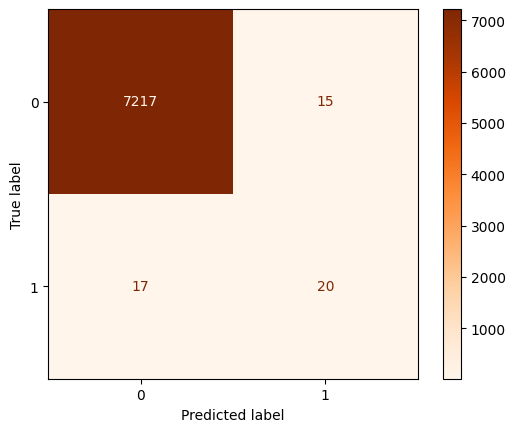

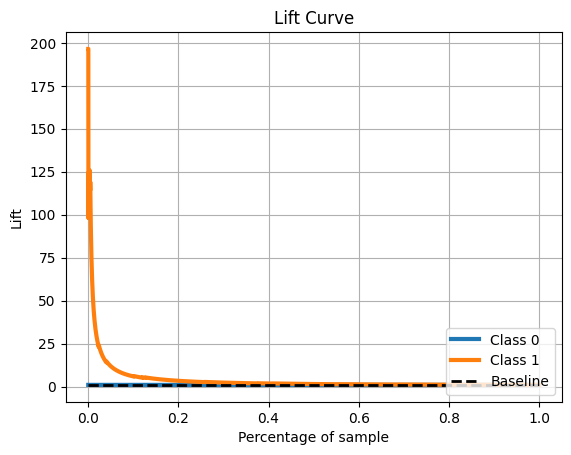

In [18]:
# testing data
stats_output, charts_output = evaluate_performance(bm_test_proba, y_test.to_numpy(), X_test, benchmark_model.model, threshold=0.3)

In [20]:
stats_output

{'metrics': {'accuracy': 0.9955977438437199,
  'precision': 0.5714285714285714,
  'recall': 0.5405405405405406,
  'f1_score': 0.5555555555555556},
 'auc': {'ROCAUC': 0.7865754305190146, 'PRAUC': 0.3457713062555123}}

Validatee model

Evaluating model performance metrics...


Model performance metrics evaluation done!


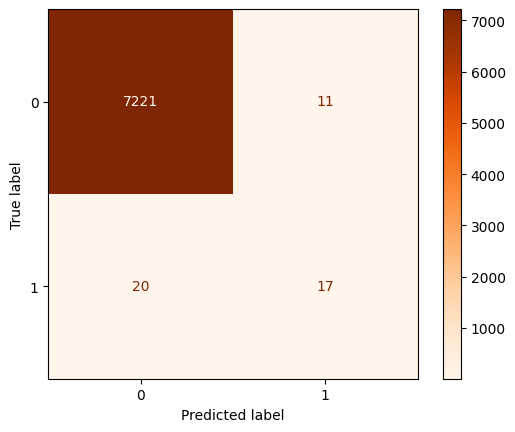

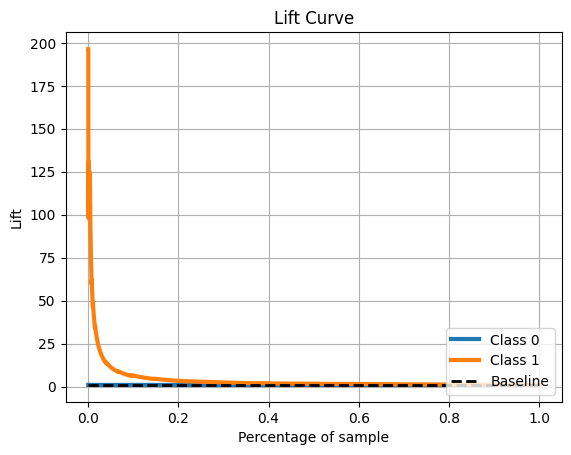

In [21]:
stats_output_vm, charts_output_vm = evaluate_performance(vm_test_proba, y_test.to_numpy(), X_test, valid_model.model, threshold=0.6)

In [22]:
stats_output_vm

{'metrics': {'accuracy': 0.9957353143486036,
  'precision': 0.6071428571428571,
  'recall': 0.4594594594594595,
  'f1_score': 0.5230769230769231},
 'auc': {'ROCAUC': 0.8151010523798135, 'PRAUC': 0.3165781921630137}}

### Statistical metrics

Benchmark model

In [35]:


class StatisticalMetricsEvaluator:
    def __init__(
        self,
        train_data: Dict[str, Union[pd.DataFrame, np.ndarray]],
        test_data: Dict[str, Union[pd.DataFrame, np.ndarray]],
    ):
        self.train_raw_X = train_data['raw_X']
        self.train_processed_X = train_data['processed_X']
        self.train_y = train_data['y']
        self.train_proba = train_data['pred_proba'][:, 1]
        self.test_raw_X = test_data['raw_X']
        self.test_processed_X = test_data['processed_X']
        self.test_y = test_data['y']
        self.test_proba = test_data['pred_proba'][:, 1]

    def _generate_output(
        self,
        bin_list: List[float],
        train_values: pd.Series,
        test_values: pd.Series
    ) -> Tuple[float, pd.DataFrame]:
        """
        Calculate the value and generate output df for psi and csi.
        """
        train_count = train_values.groupby(
            pd.cut(train_values, bin_list)).count()
        train_perc = train_count.apply(
            lambda x: x / sum(train_count))
        test_count = test_values.groupby(
            pd.cut(test_values, bin_list)).count()
        test_perc = test_count.apply(
            lambda x: x / sum(test_count))

        df_index = [
            f'({bin_list[i]:.2f}, {bin_list[i + 1]:.2f}]' for i in range(len(bin_list) - 1)]
        output_df = pd.DataFrame({
            'train_count': train_count,
            'train_perc': train_perc,
            'test_count': test_count,
            'test_perc': test_perc,
        })
        output_df.index = df_index

        x = 0
        values = []
        for _, row in output_df.iterrows():
            actual = row['train_perc']
            expected = row['test_perc']
            if actual == 0 or expected == 0:
                value = 0
            else:
                value = (actual - expected) * math.log(actual / expected)
            values.append(value)
            x = x + value
        output_df['index_value'] = values
        return x, output_df

    def calculate_psi(self, num_bins=10) -> float:
        train_proba = pd.Series(self.train_proba)
        test_proba = pd.Series(self.test_proba)
        bin_list = np.arange(0, 1+1/num_bins, 1/num_bins).tolist()
        psi, output_df = self._generate_output(
            bin_list,
            train_proba,
            test_proba
        )
        return psi, output_df

    def csi_for_single_feature(self, ft_name: str, num_bins=10):
        train_l = self.train_raw_X[ft_name]
        test_l = self.test_raw_X[ft_name]
        lower = min(min(train_l), min(test_l))
        upper = max(max(train_l), max(test_l))

        bin_list = np.arange(
            lower,
            upper + (upper - lower) / num_bins,
            (upper - lower) / num_bins
        ).tolist()

        csi, output_df = self._generate_output(
            bin_list,
            train_l,
            test_l
        )
        return csi, output_df

    def csi_for_all_features(self, ft_names: List[str], num_bins=10):
        # check_columns(self.train_raw_X, [ft_names])
        df_list = []
        csi_dict = dict()
        for feature in ft_names:
            csi, df = self.csi_for_single_feature(feature, num_bins)
            csi_dict[feature] = csi
            df_list.append(df)
        return df_list, csi_dict

    def kstest(self,
               score_col_name: str) -> float:
        return scipy.stats.ks_2samp(self.train_processed_X[score_col_name], self.test_processed_X[score_col_name])


In [36]:
stat_evaluator = StatisticalMetricsEvaluator(bm_train_data, bm_test_data)

In [37]:
bm_psi, bm_psi_df = stat_evaluator.calculate_psi()
print(bm_psi)
bm_psi_df

0.00547605071097624


,train_count,train_perc,test_count,test_perc,index_value
"(0.00, 0.10]",0,0.000000,0,0.000000,0.000000
"(0.10, 0.20]",0,0.000000,0,0.000000,0.000000
"(0.20, 0.30]",15142,0.989415,7234,0.995185,0.000034
"(0.30, 0.40]",8,0.000523,0,0.000000,0.000000
"(0.40, 0.50]",9,0.000588,4,0.000550,0.000003
"(0.50, 0.60]",18,0.001176,3,0.000413,0.000800
"(0.60, 0.70]",17,0.001111,9,0.001238,0.000014
"(0.70, 0.80]",110,0.007188,19,0.002614,0.004627
"(0.80, 0.90]",0,0.000000,0,0.000000,0.000000
"(0.90, 1.00]",0,0.000000,0,0.000000,0.000000


In [31]:
bm_csi, bm_csi_df = stat_evaluator.csi_for_single_feature('loan_amnt')
print(bm_csi)
bm_csi_df

0.002141950147752524


,train_count,train_perc,test_count,test_perc,index_value
"(1000.00, 4900.00]",1111,0.072919,590,0.081616,0.000980
"(4900.00, 8800.00]",2516,0.165135,1183,0.163646,0.000013
"(8800.00, 12700.00]",3151,0.206813,1474,0.203901,0.000041
"(12700.00, 16600.00]",2181,0.143148,1044,0.144418,0.000011
"(16600.00, 20500.00]",1896,0.124442,855,0.118274,0.000314
"(20500.00, 24400.00]",823,0.054017,394,0.054503,0.000004
"(24400.00, 28300.00]",987,0.064781,482,0.066676,0.000055
"(28300.00, 32200.00]",991,0.065043,493,0.068198,0.000149
"(32200.00, 36100.00]",727,0.047716,349,0.048278,0.000007
"(36100.00, 40000.00]",853,0.055986,365,0.050491,0.000568


In [34]:
stat_evaluator.kstest('home_ownership_ANY')

KstestResult(statistic=0.0021121890703433843, pvalue=1.0)